<a href="https://colab.research.google.com/github/apthagowda97/computer_vision_poc/blob/master/gan/notebook/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

import torch.nn.parallel
import torchvision.utils as vutils
from torch.autograd import Variable
from torchsummary import summary

In [2]:
device = "cuda"

In [3]:
batchSize = 64
imageSize = 64 

In [4]:
transform = transforms.Compose([transforms.Resize(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [123]:
dataset = dset.CIFAR10(root = './data', download = True, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 2)

Files already downloaded and verified


In [124]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [125]:
class G(nn.Module):

    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [126]:
netG = G()
netG.to(device)
netG.apply(weights_init)
summary(netG,input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [127]:
class D(nn.Module):
    def __init__(self):
        super(D,self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,128,4,2,1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),            
            nn.Conv2d(128,256,4,2,1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),           
            nn.Conv2d(256,512,4,2,1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Flatten(),
            nn.Linear((512*4*4),1,bias=False),
            nn.Sigmoid()
            
        )
        
    def forward(self,input):
        output = self.main(input)
        return output.view(-1)
    

In [128]:
netD = D()
netD.to(device)
netD.apply(weights_init)
summary(netD,input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
          Flatten-13                 [-1, 8192]               0
           Linear-14                   

In [129]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [130]:
for epoch in range(5):

    for i, data in enumerate(dataloader, 0):
        
        # 1st Step: Updating the weights of the neural network of the discriminator

        netD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real, _ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD(input.to(device))
        errD_real = criterion(output, target.to(device))
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise.to(device))
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target.to(device))
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # 2nd Step: Updating the weights of the neural network of the generator

        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target.to(device))
        errG.backward()
        optimizerG.step()

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 5, i, len(dataloader), errD.data, errG.data))

[0/25][781/782] Loss_D: 0.9984 Loss_G: 4.3192
[1/25][781/782] Loss_D: 0.7042 Loss_G: 3.6047
[2/25][781/782] Loss_D: 0.7317 Loss_G: 2.3927
[3/25][781/782] Loss_D: 1.2890 Loss_G: 4.4386
[4/25][781/782] Loss_D: 0.5459 Loss_G: 4.9181


In [131]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

In [140]:
fake_img_list = []
noise = Variable(torch.randn(batchSize, 100, 1, 1))
fake = netG(noise.to(device)).detach().cpu()
fake_img_list.append(vutils.make_grid(fake, padding=4, normalize=True))

Text(0.5, 1.0, 'fake_image')

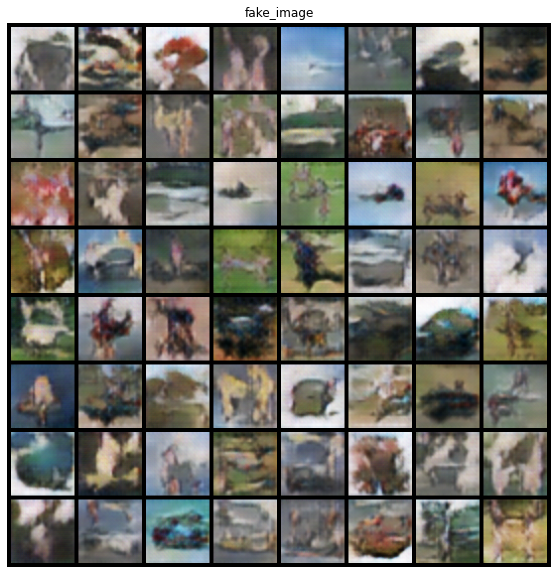

In [141]:
plt.figure(figsize=(20,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in fake_img_list]
plt.title('fake_image')

In [134]:
real_img_list = []
real_image = next(iter(dataloader))
real_img_list.append(vutils.make_grid(real_image[0], padding=4, normalize=True))

Text(0.5, 1.0, 'real_image')

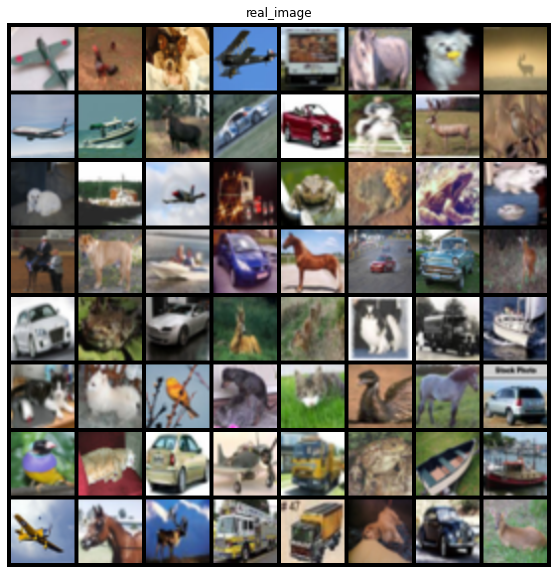

In [135]:
plt.figure(figsize=(20,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in real_img_list]
plt.title('real_image')